In [306]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from graphviz import Digraph
import torch
%matplotlib inline

In [298]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None 
        self._prev = set(_children)
        self._op = _op
        self.label = label
    
    def __repr__(self):
        return f"Value=(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad  += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self, other): # other + self
        return self + other
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other 
        return self * other**-1
    
    def __rtruediv__(self, other):
        return self * other**-1
    
    def __neg__(self):
        return self.data * -1
    
    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [299]:
def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular 'record' node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [300]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = ' x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

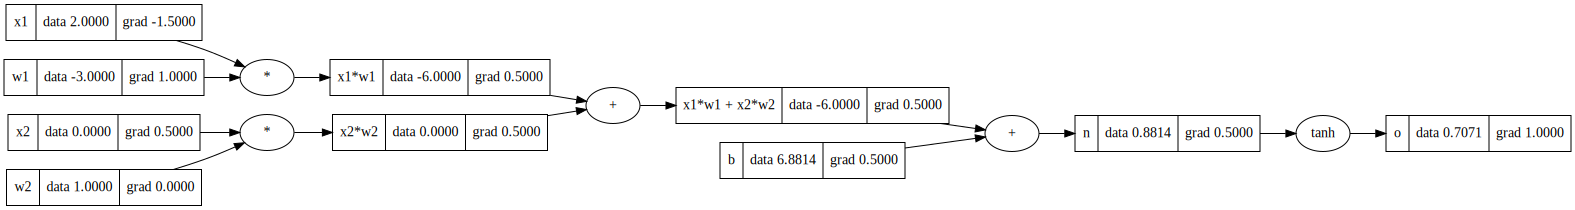

In [301]:
draw_dot(o)

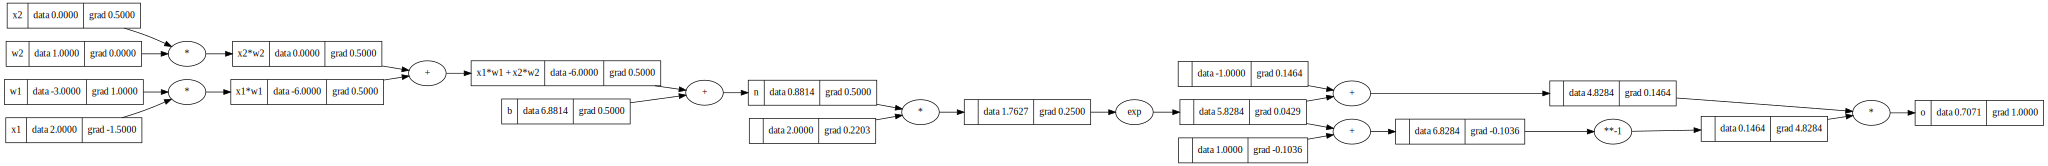

In [302]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label = 'b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = ' x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ------------
e = (n*2).exp()
o = (e - 1) / (e + 1)
# ------------
o.label = 'o'
o.backward()
draw_dot(o)

In [304]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [335]:
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


In [702]:
x = [2.0, 3.0, -1.0, 1.0]
n = MLP(4, [6, 6, 1])
n(x) 

Value=(data=-0.9594112401022186)

In [703]:
# draw_dot(n(x))

In [704]:
xs = [
    [2.0, 3.0, -1.0, 0.5],
    [3.0, -1.0, 0.5, 1.0],
    [0.5, 1.0, 1.0, 2.0],
    [1.0, 1.0, -1.0, -2.0]
]

ys = [0.5, -1.0, -0.5, 1.0]

In [707]:
for k in range(10000):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])

    # backward pass
    for p in n.parameters():
        p.grad = 0
    loss.backward()

    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad

    if k % 100 == 0:
        print(k, loss)

0 Value=(data=3.907922474043661e-05)
100 Value=(data=3.487561063042266e-05)
200 Value=(data=2.9849563965374744e-05)
300 Value=(data=2.6048192285254998e-05)
400 Value=(data=2.3896580258412286e-05)
500 Value=(data=2.3225592078590866e-05)
600 Value=(data=2.3908806157478123e-05)
700 Value=(data=2.5965715429928613e-05)
800 Value=(data=2.9297014700232518e-05)
900 Value=(data=3.306450116418137e-05)
1000 Value=(data=3.534966573190354e-05)
1100 Value=(data=3.451899778942771e-05)
1200 Value=(data=3.116026518858428e-05)
1300 Value=(data=2.7271086134123438e-05)
1400 Value=(data=2.4232619415861008e-05)
1500 Value=(data=2.242138479907744e-05)
1600 Value=(data=2.1779460526522e-05)
1700 Value=(data=2.222387186938482e-05)
1800 Value=(data=2.3739436058732082e-05)
1900 Value=(data=2.6234373347319592e-05)
2000 Value=(data=2.9188608945566226e-05)
2100 Value=(data=3.139530744506085e-05)
2200 Value=(data=3.155168976941113e-05)
2300 Value=(data=2.9528460434372472e-05)
2400 Value=(data=2.6488027927923006e-05)


In [708]:
ypred

[Value=(data=0.49707974467595384),
 Value=(data=-0.9980928457043335),
 Value=(data=-0.5018805288586182),
 Value=(data=0.9982889772220481)]